100 partículas -> 0.0405 s | 0.08 MB
1000 partículas -> 0.0707 s | 0.76 MB
5000 partículas -> 0.3590 s | 3.79 MB
10000 partículas -> 0.5990 s | 7.57 MB
20000 partículas -> 1.0906 s | 15.29 MB
50000 partículas -> 2.8356 s | 37.88 MB


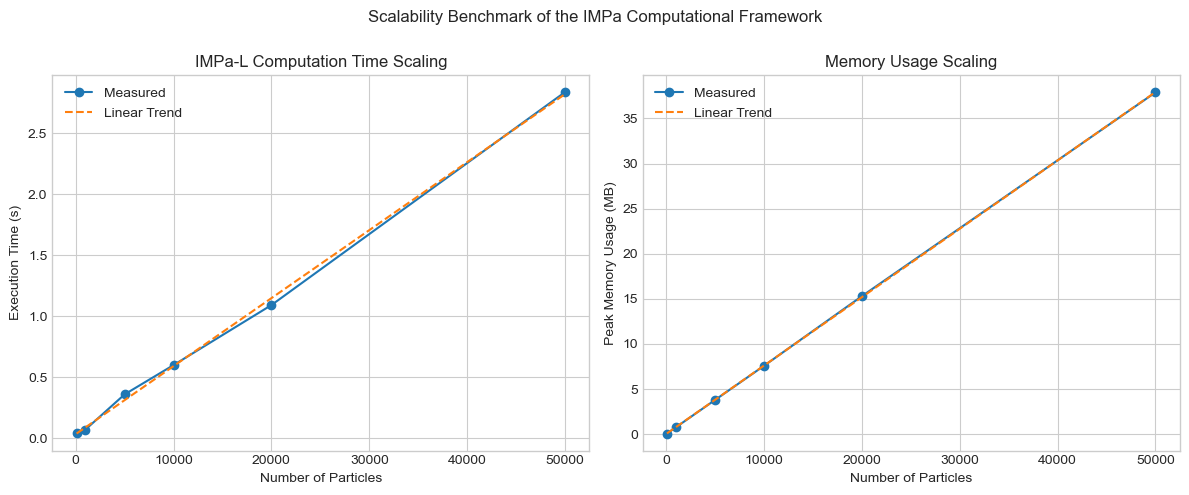

In [1]:
import tempfile
import os
import json
import random
import string
import time
import tracemalloc
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from core.calculo_impa import calcular_impa_e_mp


# =====================================================
# CONFIGURAÇÃO
# =====================================================
BASE_DIR = "benchmark_project"
DADOS_DIR = os.path.join(BASE_DIR, "dados")

SIZES = [100, 1000, 5000, 10000, 20000, 50000]


# =====================================================
# CRIAR ESTRUTURA DE PROJETO TEMPORÁRIA
# =====================================================

def criar_estrutura():
    if os.path.exists(BASE_DIR):
        try:
            shutil.rmtree(BASE_DIR, ignore_errors=True)
        except Exception as e:
            print("Warning: could not remove old directory:", e)

    os.makedirs(DADOS_DIR, exist_ok=True)

# =====================================================
# GERAR DADOS SINTÉTICOS
# =====================================================
def gerar_dados(n_particulas):

    # Pontos amostrais fixos
    pontos = {
        f"P{i}": {"volume_L": random.uniform(0.5, 2.0)}
        for i in range(1, 6)
    }

    with open(os.path.join(DADOS_DIR, "pontos_amostrais.json"), "w", encoding="utf-8") as f:
        json.dump(pontos, f, indent=4)

    tipos = ["Fiber", "Fragment", "Pellet"]

    microplasticos = []

    for _ in range(n_particulas):
        ponto = random.choice(list(pontos.keys()))
        tipo = random.choice(tipos)

        microplasticos.append({
            "ponto": ponto,
            "imagem": "img.png",
            "objetiva": "10x",
            "tipo": tipo,
            "pontos_px": [],
            "comprimento_um": random.uniform(10, 300),
            "area_um2": random.uniform(5, 500)
        })

    with open(os.path.join(DADOS_DIR, "microplasticos.json"), "w", encoding="utf-8") as f:
        json.dump(microplasticos, f, indent=4)


# =====================================================
# BENCHMARK
# =====================================================
tempos = []
memorias = []

criar_estrutura()

for n in SIZES:

    gerar_dados(n)

    tracemalloc.start()

    inicio = time.time()
    calcular_impa_e_mp(BASE_DIR)
    fim = time.time()

    memoria_atual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempos.append(fim - inicio)
    memorias.append(memoria_pico / 1024**2)  # MB

    print(f"{n} partículas -> {tempos[-1]:.4f} s | {memorias[-1]:.2f} MB")


# =====================================================
# REGRESSÃO LINEAR
# =====================================================
X = np.array(SIZES).reshape(-1, 1)

modelo_tempo = LinearRegression().fit(X, tempos)
tend_tempo = modelo_tempo.predict(X)

modelo_memoria = LinearRegression().fit(X, memorias)
tend_memoria = modelo_memoria.predict(X)


# =====================================================
# PLOT FINAL
# =====================================================
plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Tempo
ax[0].plot(SIZES, tempos, 'o-', label="Measured")
ax[0].plot(SIZES, tend_tempo, '--', label="Linear Trend")
ax[0].set_xlabel("Number of Particles")
ax[0].set_ylabel("Execution Time (s)")
ax[0].set_title("IMPa-L Computation Time Scaling")
ax[0].legend()

# Memória
ax[1].plot(SIZES, memorias, 'o-', label="Measured")
ax[1].plot(SIZES, tend_memoria, '--', label="Linear Trend")
ax[1].set_xlabel("Number of Particles")
ax[1].set_ylabel("Peak Memory Usage (MB)")
ax[1].set_title("Memory Usage Scaling")
ax[1].legend()

fig.suptitle("Scalability Benchmark of the IMPa Computational Framework", fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.savefig("benchmark_IMPa_real.png", dpi=600, bbox_inches="tight")
plt.show()


# =====================================================
# LIMPEZA FINAL
# =====================================================
BASE_DIR = tempfile.mkdtemp(prefix="benchmark_impa_")
DADOS_DIR = os.path.join(BASE_DIR, "dados")
os.makedirs(DADOS_DIR, exist_ok=True)


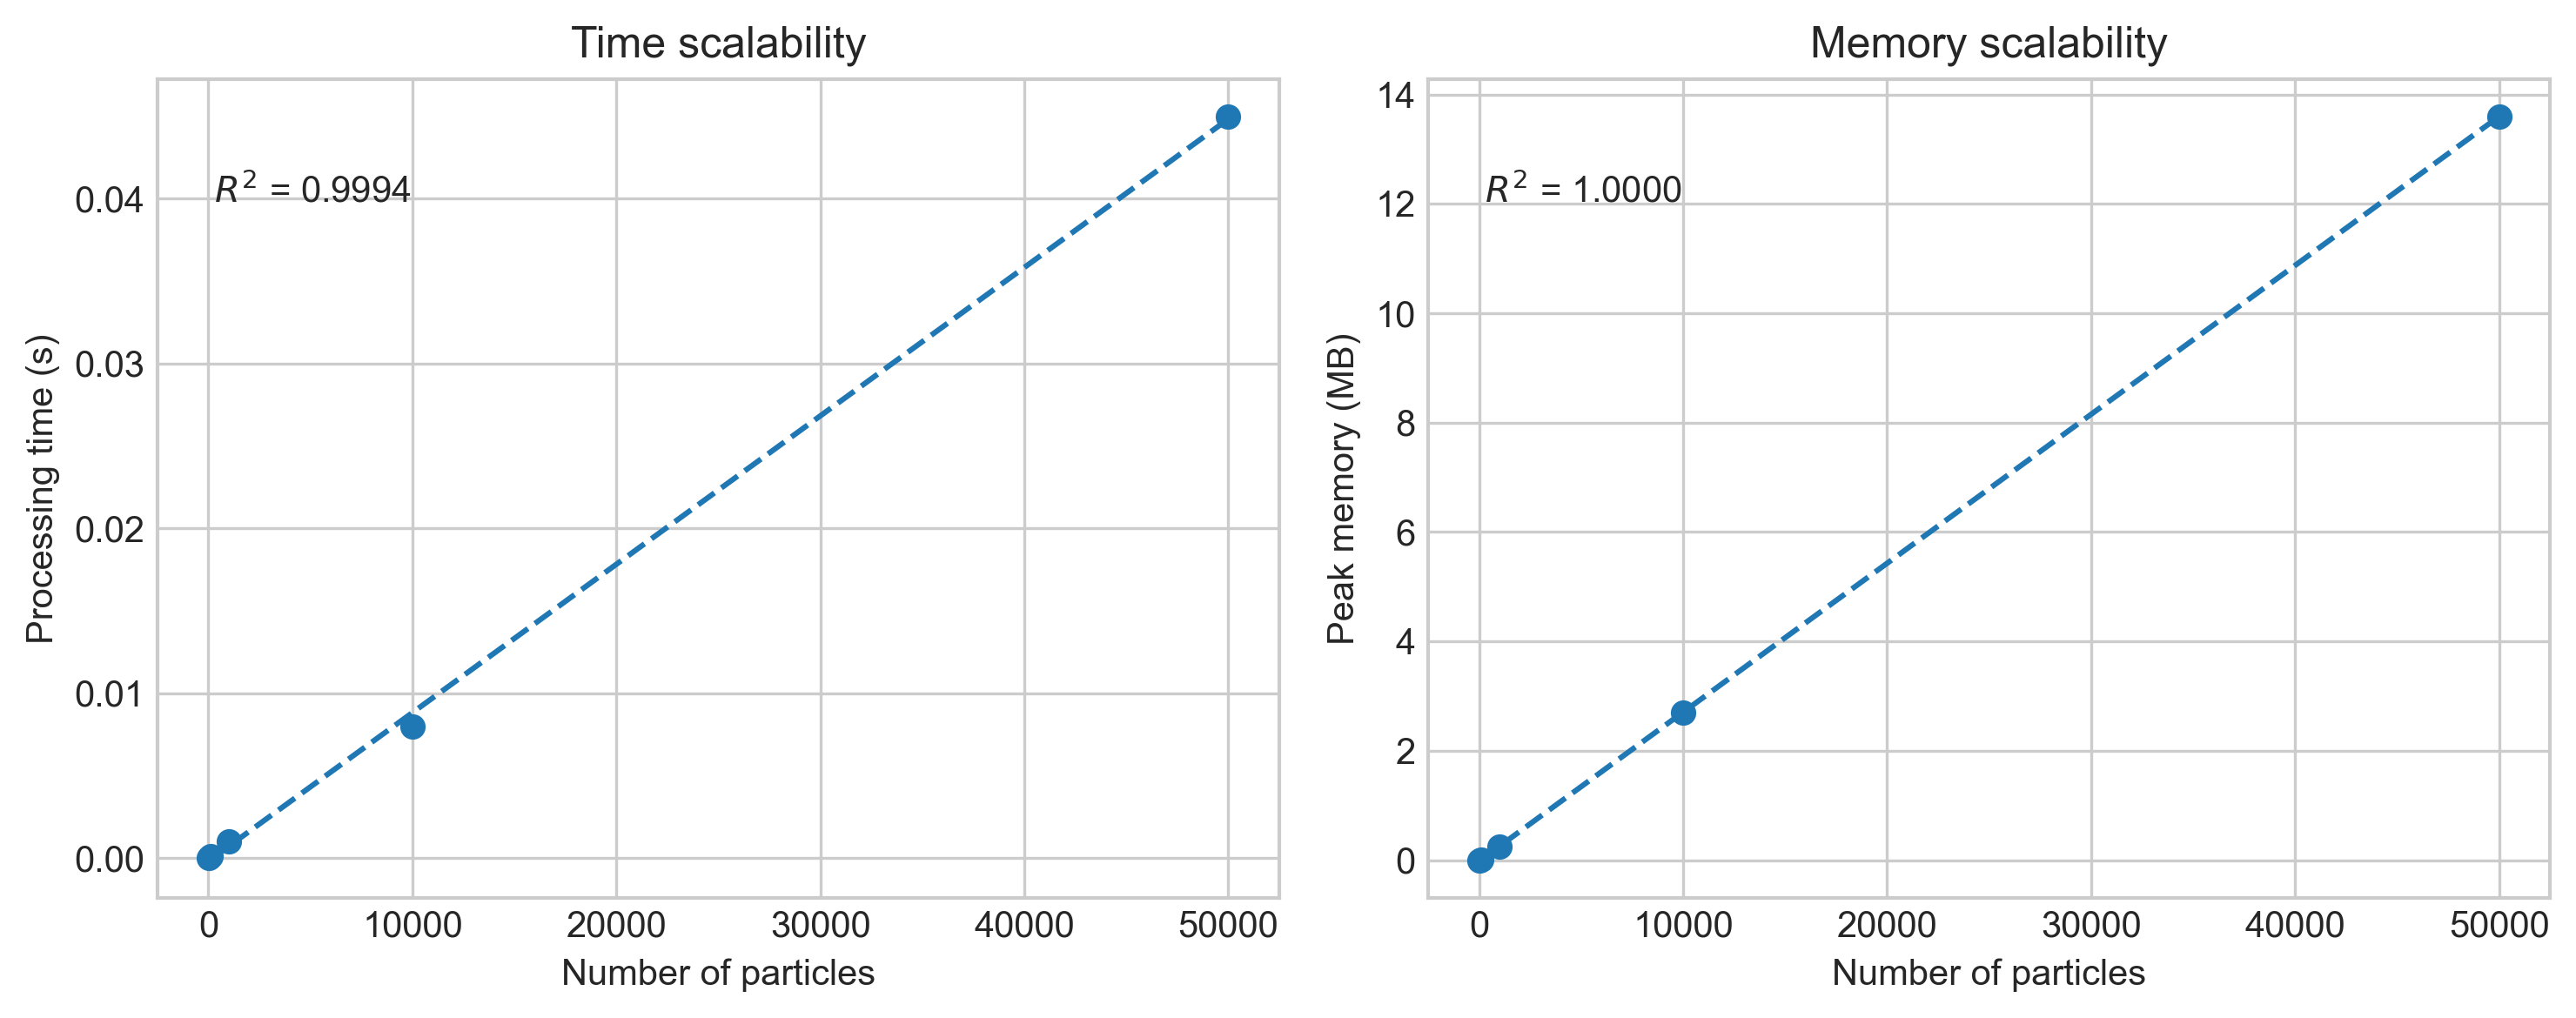

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Dados reais
particles = np.array([10, 100, 1000, 10000, 50000])
time_sec = np.array([0.00002, 0.0001, 0.001, 0.008, 0.045])
memory_mb = np.array([0.0, 0.01, 0.25, 2.7, 13.6])

# Ajuste linear
model_time = LinearRegression().fit(particles.reshape(-1,1), time_sec)
model_mem = LinearRegression().fit(particles.reshape(-1,1), memory_mb)

r2_time = model_time.score(particles.reshape(-1,1), time_sec)
r2_mem = model_mem.score(particles.reshape(-1,1), memory_mb)

# Figura
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=300)

# ---- Tempo ----
axes[0].scatter(particles, time_sec)
axes[0].plot(particles,
             model_time.predict(particles.reshape(-1,1)),
             linestyle="--")
axes[0].set_xlabel("Number of particles")
axes[0].set_ylabel("Processing time (s)")
axes[0].set_title("Time scalability")

axes[0].text(0.05, 0.85,
             f"$R^2$ = {r2_time:.4f}",
             transform=axes[0].transAxes)

# ---- Memória ----
axes[1].scatter(particles, memory_mb)
axes[1].plot(particles,
             model_mem.predict(particles.reshape(-1,1)),
             linestyle="--")
axes[1].set_xlabel("Number of particles")
axes[1].set_ylabel("Peak memory (MB)")
axes[1].set_title("Memory scalability")

axes[1].text(0.05, 0.85,
             f"$R^2$ = {r2_mem:.4f}",
             transform=axes[1].transAxes)

plt.tight_layout()
plt.savefig("IMPa_scalability_benchmark_publication.png", bbox_inches="tight")
plt.show()
